In [2]:
import zipfile
zf = 'D:\ROUGH\pneumonia-xray-images.zip'
target_dir = 'D:\ROUGH\dataset\cnn\pneumonia_revamped'
zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

train_path = 'D:/ROUGH/dataset/cnn/pneumonia_revamped/train'
test_path = 'D:/ROUGH/dataset/cnn/pneumonia_revamped/test'
val_path = 'D:/ROUGH/dataset/cnn/pneumonia_revamped/val'

batch_size = 16

img_height = 500
img_width = 500


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_gen = ImageDataGenerator(rescale = 1./255,
                              shear_range = 0.2,
                              zoom_range = 0.2,
                              horizontal_flip=True)

test_data_gen = ImageDataGenerator(rescale = 1./255)

In [6]:
train = image_gen.flow_from_directory(train_path,
                                     target_size = (img_height, img_width),
                                     color_mode = 'grayscale',
                                     class_mode = 'binary',
                                     batch_size = batch_size)

test = test_data_gen.flow_from_directory(test_path,
                                        target_size = (img_height, img_width),
                                        color_mode = 'grayscale',
                                        shuffle = True,
                                        class_mode = 'binary',
                                        batch_size = batch_size)

valid = test_data_gen.flow_from_directory(val_path,
                                         target_size = (img_height, img_width),
                                         color_mode = 'grayscale',
                                         class_mode = 'binary',
                                         batch_size = batch_size)

Found 4192 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1040 images belonging to 2 classes.


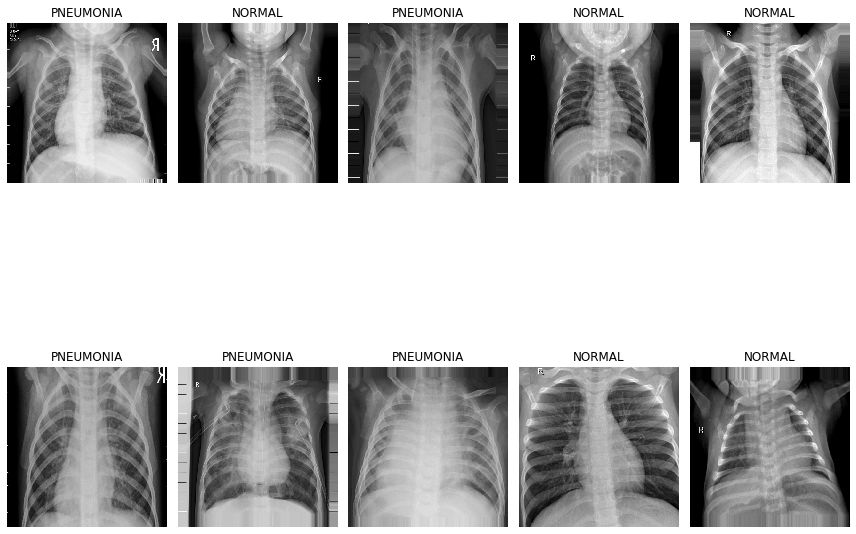

In [7]:
plt.figure(figsize=(12, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train:
        image = X_batch[0]        
        dic = {0:'NORMAL', 1:'PNEUMONIA'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [9]:
cnn = Sequential()

cnn.add(Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width, 1)))
cnn.add(MaxPooling2D(pool_size = (2,2)))

cnn.add(Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width, 1)))
cnn.add(MaxPooling2D(pool_size = (2,2)))

cnn.add(Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width, 1)))
cnn.add(MaxPooling2D(pool_size = (2,2)))

cnn.add(Conv2D(64, (3,3), activation='relu', input_shape=(img_height, img_width, 1)))
cnn.add(MaxPooling2D(pool_size = (2,2)))

cnn.add(Conv2D(64, (3,3), activation='relu', input_shape=(img_height, img_width, 1)))
cnn.add(MaxPooling2D(pool_size = (2,2)))

cnn.add(Flatten())

cnn.add(Dense(activation='relu', units = 128))
cnn.add(Dense(activation='relu', units = 64))
cnn.add(Dense(activation='sigmoid', units = 1))

cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [10]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 498, 498, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 249, 249, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 247, 247, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 123, 123, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 121, 121, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 60, 60, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 58, 58, 64)        1

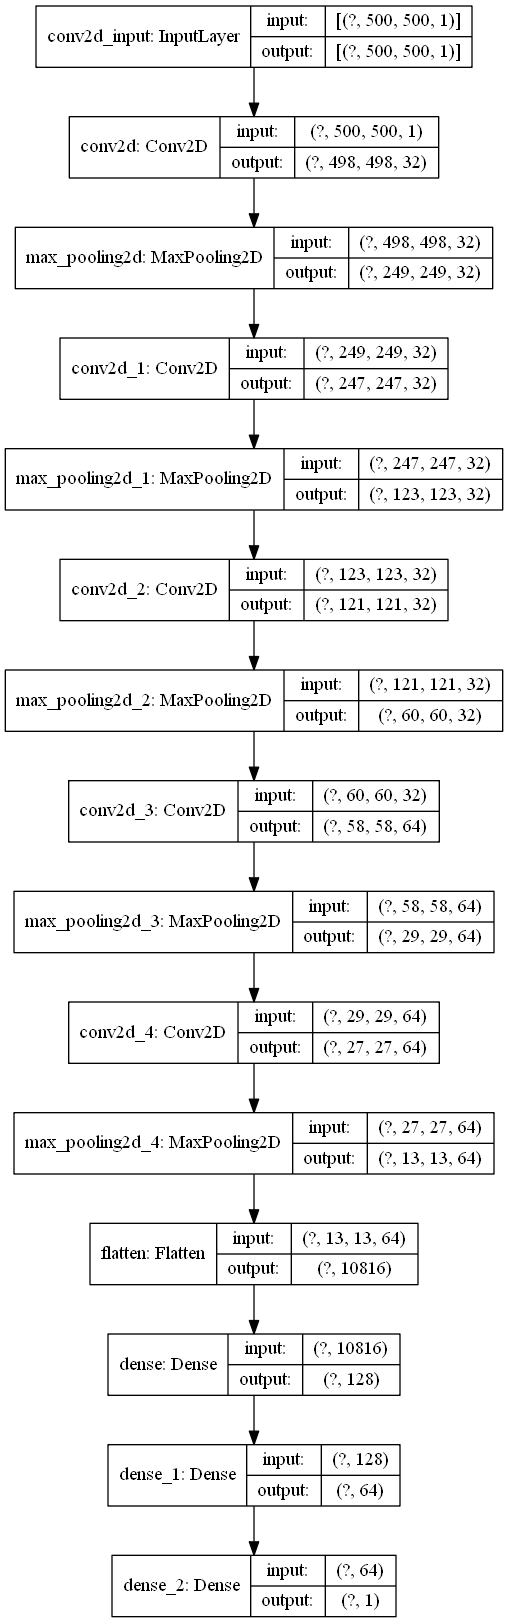

In [11]:
from tensorflow.keras.utils import plot_model

plot_model(cnn, show_shapes = True, show_layer_names = True, rankdir = 'TB', expand_nested = True)

In [12]:
early = EarlyStopping(monitor='val_loss', mode='min', patience = 3)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, varbose = 1, factor = 0.3, min_lr = 0.000001)

callback_list = [early, learning_rate_reduction]

In [13]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced', np.unique(train.classes), train.classes)
cw = dict(zip(np.unique(train.classes), weights))
print(cw)

{0: 1.9371534195933457, 1: 0.6739549839228296}


C:\Users\rohit\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [14]:
cnn.fit(train, epochs=5, validation_data = valid, class_weight = cw, callbacks = callback_list)

Epoch 1/5
262/262 [==============================] - 606s 2s/step - loss: 0.4555 - accuracy: 0.7538 - val_loss: 0.2525 - val_accuracy: 0.9087
Epoch 2/5
262/262 [==============================] - 567s 2s/step - loss: 0.2380 - accuracy: 0.8977 - val_loss: 0.2282 - val_accuracy: 0.9048
Epoch 3/5
262/262 [==============================] - 564s 2s/step - loss: 0.2169 - accuracy: 0.9084 - val_loss: 0.1983 - val_accuracy: 0.9250
Epoch 4/5
262/262 [==============================] - 557s 2s/step - loss: 0.2068 - accuracy: 0.9170 - val_loss: 0.1657 - val_accuracy: 0.9452
Epoch 5/5
262/262 [==============================] - 562s 2s/step - loss: 0.1702 - accuracy: 0.9284 - val_loss: 0.2630 - val_accuracy: 0.8837


<AxesSubplot:>

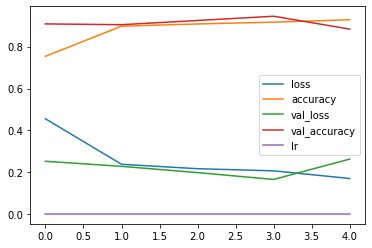

In [15]:
pd.DataFrame(cnn.history.history).plot()

In [16]:
test_acc = cnn.evaluate(test)

39/39 [==============================] - 16s 399ms/step - loss: 0.2453 - accuracy: 0.9135


In [17]:
pred = cnn.predict(test, verbose=1)

39/39 [==============================] - 15s 396ms/step


In [18]:
predictions = pred.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

In [19]:
from sklearn.metrics import classification_report
print(classification_report(y_true = test.classes, y_pred = predictions, target_names = ['NORMAL', 'PNEUMONIA']))

              precision    recall  f1-score   support

      NORMAL       0.38      0.37      0.38       234
   PNEUMONIA       0.63      0.64      0.63       390

    accuracy                           0.54       624
   macro avg       0.51      0.51      0.51       624
weighted avg       0.54      0.54      0.54       624



In [20]:
test.reset()
x = np.concatenate([test.next()[0] for i in range(test.__len__())])
y = np.concatenate([test.next()[1] for i in range(test.__len__())])
print(x.shape)
print(y.shape)

(624, 500, 500, 1)
(624,)


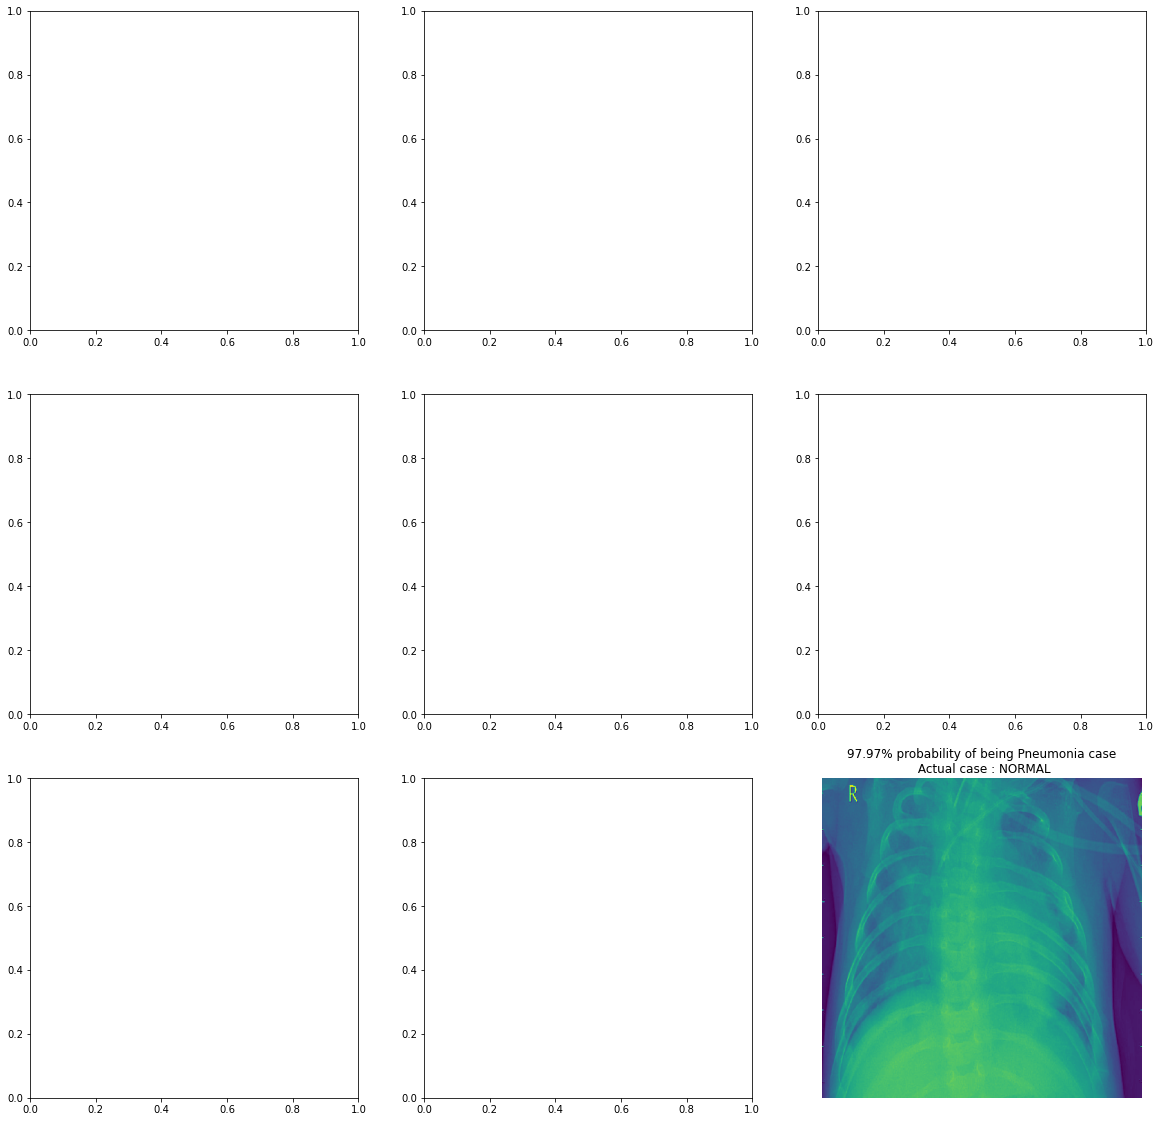

In [29]:
dic = {0:'NORMAL', 1:'PNEUMONIA'}
plt.figure(figsize=(20,20))
for i in range(0+228, 9+228):
  plt.subplot(3, 3, (i-228)+1)
  if pred[i, 0] >= 0.5: 
      out = ('{:.2%} probability of being Pneumonia case'.format(pred[i][0]))
      
      
  else: 
      out = ('{:.2%} probability of being Normal case'.format(1-pred[i][0]))
plt.title(out+"\n Actual case : "+ dic.get(y[i]))    
plt.imshow(np.squeeze(x[i]))
plt.axis('off')
plt.show()